<a href="https://colab.research.google.com/github/Fangelito/Guadiamar/blob/master/ShannonIndex_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📍 Área: Lanzarote, Las Palmas, Canarias, España
   Centro: (29.0397, -13.6363)  |  Radio: 25 km


Descargando GBIF: 10200it [04:42, 36.06it/s]


🔢 Registros descargados: 10117


Riqueza (S),994
Shannon (H'),5.573
Simpson (1-D),0.991
Registros totales,10117
Categoría,✅ 🟢 Alta diversidad


/tmp/ipython-input-36710950.py:139: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.head(15).values, y=counts.head(15).index, palette="viridis")


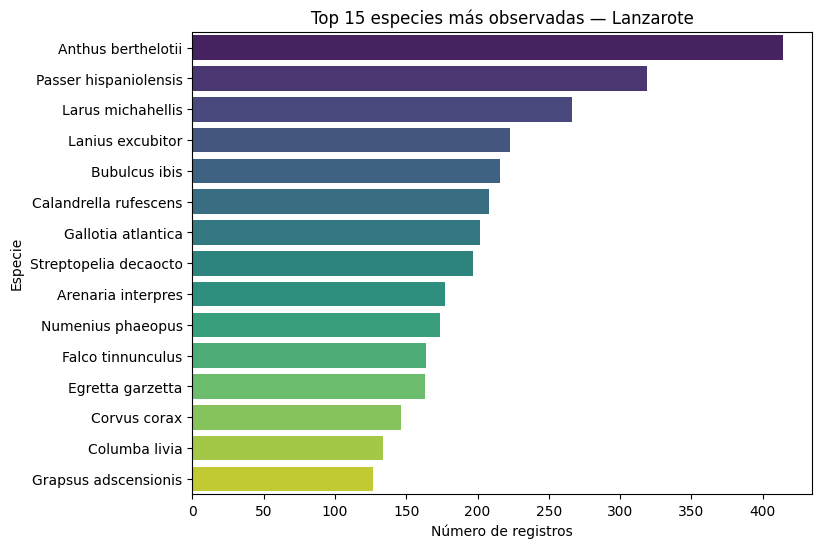

/tmp/ipython-input-36710950.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=taxon_counts.values, y=taxon_counts.index, palette="crest")


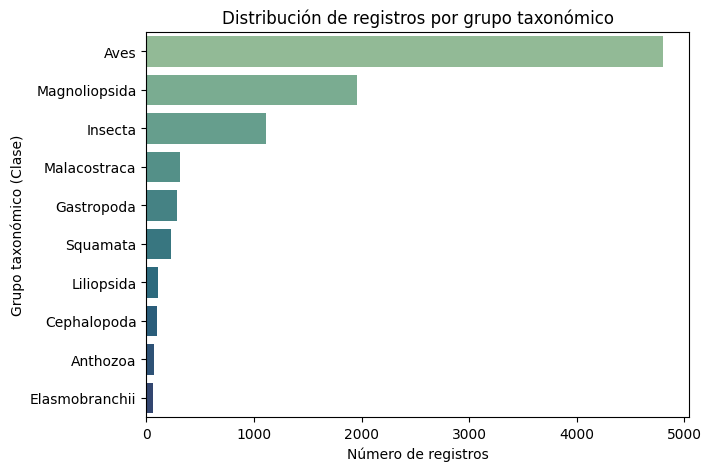

💾 CSV guardado: gbif_Lanzarote.csv


In [1]:
# ==========================================================
# 🌿 ÍNDICE DE DIVERSIDAD DE ESPECIES (versión avanzada con gráficas)
# Compatible 100 % con Google Colab
# Autor: Félix A. González Peñaloza
# ==========================================================

# 1️⃣ Instalar dependencias
!pip install requests pandas folium tqdm matplotlib seaborn --quiet

# 2️⃣ Importar librerías
import requests, math
import pandas as pd
import folium
from folium.plugins import MarkerCluster
from tqdm import tqdm
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

# 3️⃣ Parámetros del usuario
AREA_NOMBRE = "Lanzarote"   # 👈 cambia por el área deseada
PAIS_CODIGO = "ES"          # código ISO-2 (opcional)
RADIO_KM = 25               # radio alrededor del centro
MAX_REG = 10000             # máximo de registros a descargar

# 4️⃣ Geocodificación con Nominatim (OpenStreetMap)
def geocode_bbox(nombre, radio_km=25):
    url = "https://nominatim.openstreetmap.org/search"
    params = {"q": nombre, "format": "json", "limit": 1}
    r = requests.get(url, params=params, headers={"User-Agent": "biodiversity-tool"})
    res = r.json()
    if not res:
        return None
    lat = float(res[0]["lat"])
    lon = float(res[0]["lon"])
    dlat = radio_km / 111.0
    dlon = radio_km / (111.0 * max(0.1, math.cos(math.radians(lat))))
    bbox = (lat - dlat, lon - dlon, lat + dlat, lon + dlon)
    return {"lat": lat, "lon": lon, "bbox": bbox, "display_name": res[0].get("display_name", nombre)}

geo = geocode_bbox(AREA_NOMBRE, RADIO_KM)
if not geo:
    raise SystemExit("❌ No se pudo geocodificar el área. Usa un nombre más específico.")

lat, lon = geo["lat"], geo["lon"]
lat_min, lon_min, lat_max, lon_max = geo["bbox"]
print(f"📍 Área: {geo['display_name']}")
print(f"   Centro: ({lat:.4f}, {lon:.4f})  |  Radio: {RADIO_KM} km")

# 5️⃣ Descargar registros GBIF
def descargar_gbif_bbox(bbox, pais=None, max_reg=10000):
    lat_min, lon_min, lat_max, lon_max = bbox
    url = "https://api.gbif.org/v1/occurrence/search"
    page_limit, offset, registros = 300, 0, []

    with tqdm(total=max_reg, desc="Descargando GBIF", ncols=90) as pbar:
        while offset < max_reg:
            params = {
                "decimalLatitude": f"{lat_min},{lat_max}",
                "decimalLongitude": f"{lon_min},{lon_max}",
                "hasCoordinate": "true",
                "limit": page_limit,
                "offset": offset
            }
            if pais:
                params["country"] = pais

            resp = requests.get(url, params=params, headers={"User-Agent": "biodiversity-tool"})
            data = resp.json()
            results = data.get("results", [])
            if not results:
                break

            for d in results:
                sp = d.get("species")
                taxon = d.get("class")
                lat = d.get("decimalLatitude")
                lon = d.get("decimalLongitude")
                if sp and lat and lon:
                    registros.append({"species": sp, "taxon": taxon, "lat": lat, "lon": lon})

            offset += page_limit
            pbar.update(page_limit)
            if offset >= data.get("count", 0):
                break
    return pd.DataFrame(registros)

df = descargar_gbif_bbox(geo["bbox"], pais=PAIS_CODIGO, max_reg=MAX_REG)
print(f"\n🔢 Registros descargados: {len(df)}")

if df.empty:
    raise SystemExit("⚠️ No se encontraron registros de especies para este área.")

# 6️⃣ Cálculo de índices de diversidad
def indices_diversidad(df):
    counts = df["species"].value_counts()
    N = counts.sum()
    H = -sum((n/N) * math.log(n/N) for n in counts)
    D = 1 - sum((n/N)**2 for n in counts)
    return len(counts), H, D, counts

S, H, D, counts = indices_diversidad(df)

# 7️⃣ Semáforo ecológico
if H < 1:
    color, texto, emoji = "#e74c3c", "🔴 Baja diversidad", "❌"
elif H < 2:
    color, texto, emoji = "#f1c40f", "🟡 Diversidad moderada", "⚠️"
else:
    color, texto, emoji = "#2ecc71", "🟢 Alta diversidad", "✅"

# 8️⃣ Mostrar resumen
html = f"""
<h3>📊 Resultados de biodiversidad — {AREA_NOMBRE}</h3>
<table style='border-collapse:collapse;'>
<tr><td><b>Riqueza (S)</b></td><td>{S}</td></tr>
<tr><td><b>Shannon (H')</b></td><td>{H:.3f}</td></tr>
<tr><td><b>Simpson (1-D)</b></td><td>{D:.3f}</td></tr>
<tr><td><b>Registros totales</b></td><td>{len(df)}</td></tr>
<tr><td><b>Categoría</b></td>
<td style='background-color:{color};color:white;font-weight:bold;text-align:center;'>
{emoji} {texto}</td></tr>
</table>
"""
display(HTML(html))

# 9️⃣ Mapa interactivo
m = folium.Map(location=[lat, lon], zoom_start=10, tiles="OpenStreetMap")
folium.Rectangle(bounds=[(lat_min, lon_min), (lat_max, lon_max)],
                 color="#3388ff", fill=False, weight=2).add_to(m)
cluster = MarkerCluster().add_to(m)
for _, r in df.iterrows():
    folium.Marker([r["lat"], r["lon"]],
                  popup=f"{r['species']} ({r['taxon']})").add_to(cluster)
m

# 🔟 Gráfica 1 — Top 15 especies más observadas
plt.figure(figsize=(8, 6))
sns.barplot(x=counts.head(15).values, y=counts.head(15).index, palette="viridis")
plt.title(f"Top 15 especies más observadas — {AREA_NOMBRE}")
plt.xlabel("Número de registros")
plt.ylabel("Especie")
plt.show()

# 11️⃣ Gráfica 2 — Distribución por grupo taxonómico
taxon_counts = df['taxon'].value_counts().head(10)
plt.figure(figsize=(7, 5))
sns.barplot(x=taxon_counts.values, y=taxon_counts.index, palette="crest")
plt.title("Distribución de registros por grupo taxonómico")
plt.xlabel("Número de registros")
plt.ylabel("Grupo taxonómico (Clase)")
plt.show()

# 12️⃣ Exportar CSV
out_csv = f"gbif_{AREA_NOMBRE.replace(' ', '_')}.csv"
df.to_csv(out_csv, index=False)
print(f"💾 CSV guardado: {out_csv}")
